## Libraries

In [50]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns

import pyodbc #for connection to the database

import pmdarima as pm

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
%matplotlib inline

from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller #for Augmented Dickey fuller test
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from statsmodels.graphics.tsaplots import plot_acf #For Autocorrelation
from statsmodels.graphics.tsaplots import plot_pacf #For Partial Autocorrelation

import statsmodels.api as sm

from pandas.plotting import register_matplotlib_converters

from pandas.plotting import autocorrelation_plot

import warnings
warnings.filterwarnings("ignore")

register_matplotlib_converters()

In [2]:
%pwd

'C:\\Users\\jsingh\\Desktop\\Work\\SalesPrediction'

## Database Connection

Creating the connection to the _ExactMAXCaseMedical_ database

In [3]:
connection = pyodbc.connect("Driver={ODBC Driver 17 for SQL Server}; Server=SQLSERVERTEST;Database=ExactMAXCaseMedical;uid=sa;pwd=Twotbgrar2020!")
print(connection)

In [4]:
#Query for extracting the data we want
sql_query="SELECT CONCAT(MONTH(CreationDate), '-', YEAR(CreationDate)) as Date, SUM(CURQTY_28) as Orders FROM [ExactMAXCaseMedical].[dbo].[SO_Detail] WHERE YEAR(CreationDate) > 2017  group by MONTH(CreationDate), YEAR(CreationDate)   order by YEAR(CreationDate), MONTH(CreationDate)"

We are considering order from 2018 onwards, for our analysis. <br>
In the SQL query we are only returning Date and Orders columns. We have grouped the data for each month per year.

Since, main goal of this analysis is forecasting orders and making time series model, we only be requiring Data and Orders column only

In [5]:
df= pd.read_sql(sql_query, connection)
df.head(5)

,Date,Orders
0,1-2018,14375.67
1,2-2018,15635.32
2,3-2018,13526.79
3,4-2018,19046.00
4,5-2018,11703.39


In [6]:
df.tail()

,Date,Orders
32,9-2020,20597.52
33,10-2020,81762.00
34,11-2020,43255.55
35,12-2020,33082.96
36,1-2021,34195.00


In [7]:
df.shape

(37, 2)

There are total 37 rows and 2 columns(Date, Number of orders). <br>


In [8]:
# Converting Date into Datetime format
df['Date']=pd.to_datetime(df['Date'])

In [9]:
df.head()

,Date,Orders
0,2018-01-01,14375.67
1,2018-02-01,15635.32
2,2018-03-01,13526.79
3,2018-04-01,19046.00
4,2018-05-01,11703.39


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    37 non-null     datetime64[ns]
 1   Orders  37 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 720.0 bytes


As we can see there are no Null Values in our data

In [11]:
#basic statistics
df.describe()

,Orders
count,37.000000
mean,33400.916216
std,23359.345363
min,11703.390000
25%,17307.730000
50%,22161.030000
75%,37685.030000
max,87860.080000


In [12]:
#Plotting Date vs Number of Orders graph

def plot_df(df, x, y, title="", xlabel='Date', ylabel='Orders', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.plot(x, y, color='tab:Blue', marker='o')
    plt.show()

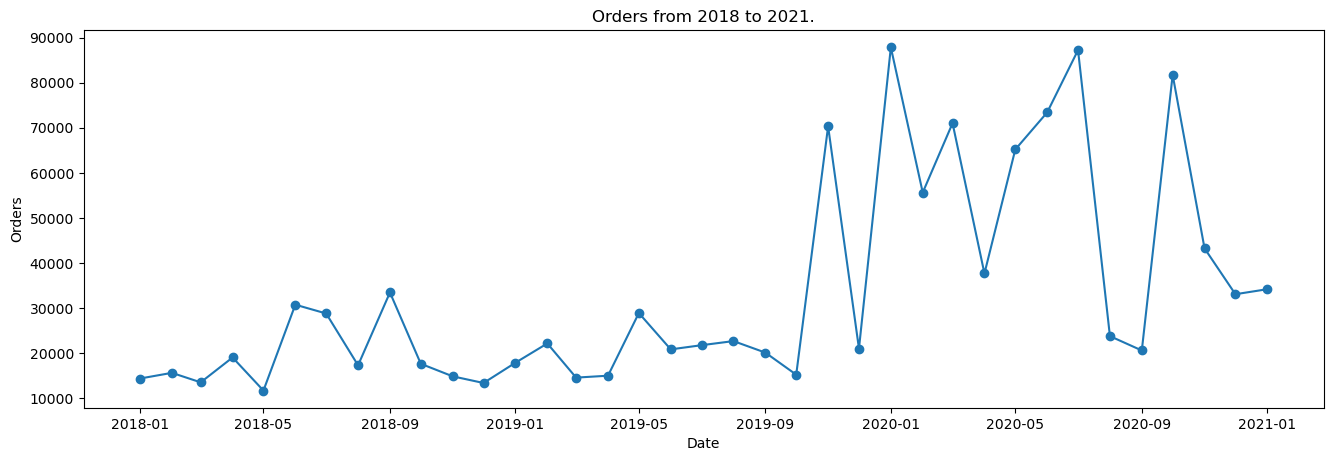

In [13]:
plot_df(df, x=df.Date, y=df.Orders,title='Orders from 2018 to 2021.')

In [14]:
df['Year'] = [d.year for d in df.Date]
df['Month'] = [d.strftime('%b') for d in df.Date]
years = df['Year'].unique()

In [15]:
df.head()

,Date,Orders,Year,Month
0,2018-01-01,14375.67,2018,Jan
1,2018-02-01,15635.32,2018,Feb
2,2018-03-01,13526.79,2018,Mar
3,2018-04-01,19046.00,2018,Apr
4,2018-05-01,11703.39,2018,May


In [16]:
#Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)


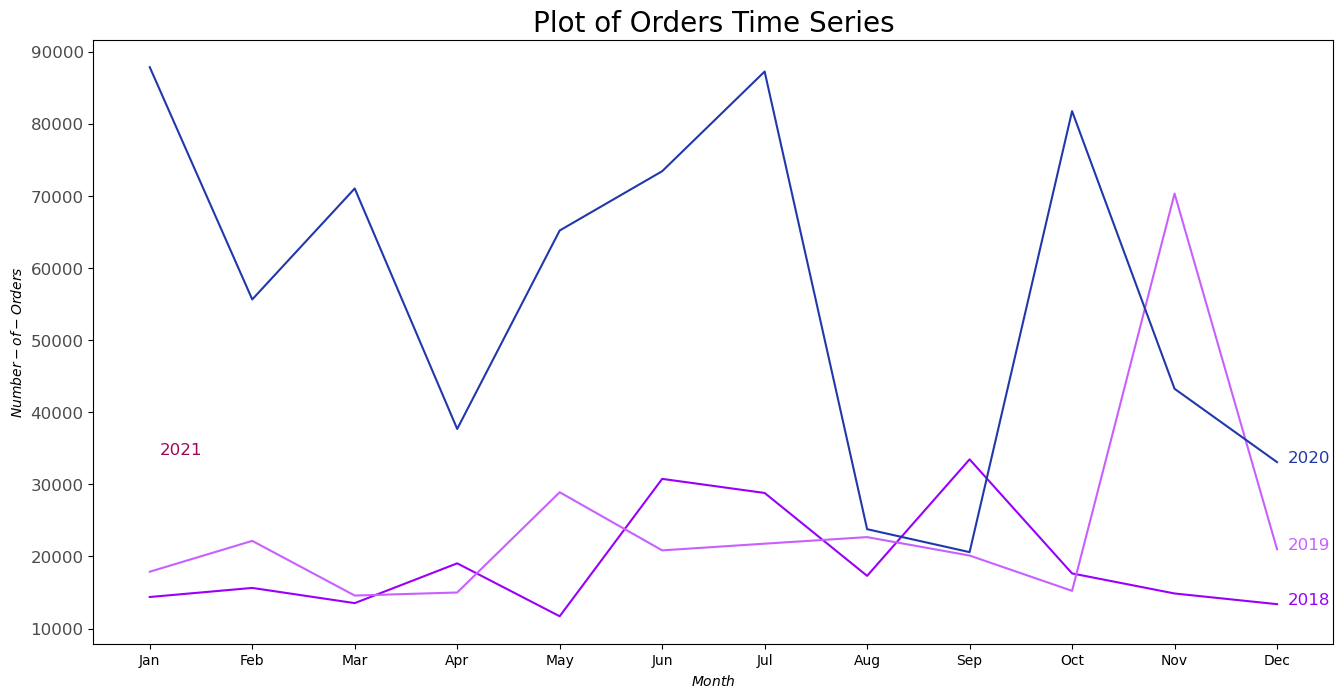

In [17]:
#Time Series graph for plotting the number of order in each per year- year wise
plt.figure(figsize=(16,8), dpi= 100)
for i, y in enumerate(years):
    if i >= 0:        
        plt.plot('Month', 'Orders', data=df.loc[df.Year==y, :], color=mycolors[i], label=y)
        plt.text(df.loc[df.Year==y, :].shape[0]-.9, df.loc[df.Year==y, 'Orders'][-1:].values[0], y, fontsize=12, color=mycolors[i])


# Decoration
plt.gca().set(ylabel='$Number-of-Orders$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Plot of Orders Time Series", fontsize=20)
plt.show()

It can be clearly seen that the number of orders were the most in the year 2021. 

<AxesSubplot:xlabel='Month', ylabel='Orders'>

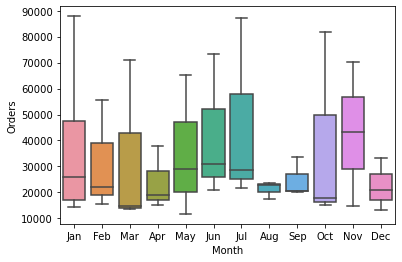

In [18]:
#Month-wise trend
sns.boxplot(x='Month', y='Orders', data=df)

The above box-plot shows the distribution of data (month-wise). Its representing the five number summary(_Minimum, 1st Quartile (Q1),Median, 3rd Quartile(Q3) and Maximum_)
<br>
<br>
There are no Outliers 

<img src="images/Capture.PNG" width="500" height="500">

In [19]:
#Copying the columns to another dataframe
df_series= df[["Date", "Orders"]].copy()

In [20]:
#Setting Date column as the Index of the data frame
df_series.set_index('Date',inplace=True)

In [21]:
df_series.head()

,Orders
Date,
2018-01-01,14375.67
2018-02-01,15635.32
2018-03-01,13526.79
2018-04-01,19046.00
2018-05-01,11703.39


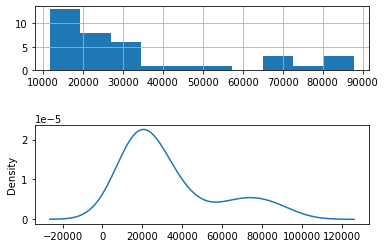

In [22]:
plt.figure(1)
plt.subplot(311)
df_series["Orders"].hist()
plt.subplot(212)
df_series["Orders"].plot(kind='kde') #kde- Kernel density function
plt.show()

The Histogram shows how the count of _Orders_ are distributed in each bin. 
<br>
Density plot below shows the distribution of _Orders_ in the data. We can say that our data is right-skewed meaning it has long right tail (positive-skew)

### Decomposing time series into it's components

Decomposition reduces a time series into 3 components: trend, seasonal effects, and random errors.

– Trend: Shows how things are overall changing
<br>
– Seasonality: Shows how things change within a given period e.g. a year, month, week, day
<br>
– Error/ Residual: activity not explained by the trend or the seasonal value

In a <STRONG>_multiplicative time series_</STRONG>, the components multiply together to make the time series. If you have an increasing trend, the amplitude of seasonal activity increases. Everything becomes more exaggerated. 
<br>
<br>
In an <STRONG>_additive time series_</STRONG>, the components add together to make the time series. If you have an increasing trend, you still see roughly the same size peaks and troughs throughout the time series. 

<strong>After decomposition we can see that there is an upward trend in the time series. Also, there is Sesonality in the data. Which makes us believe that SARIMA would be a better choice for our time series forecasting, since there is seasonality in the data.</strong>

However, we will be implementing both ARIMA and SARIMA to check how both models work on our data

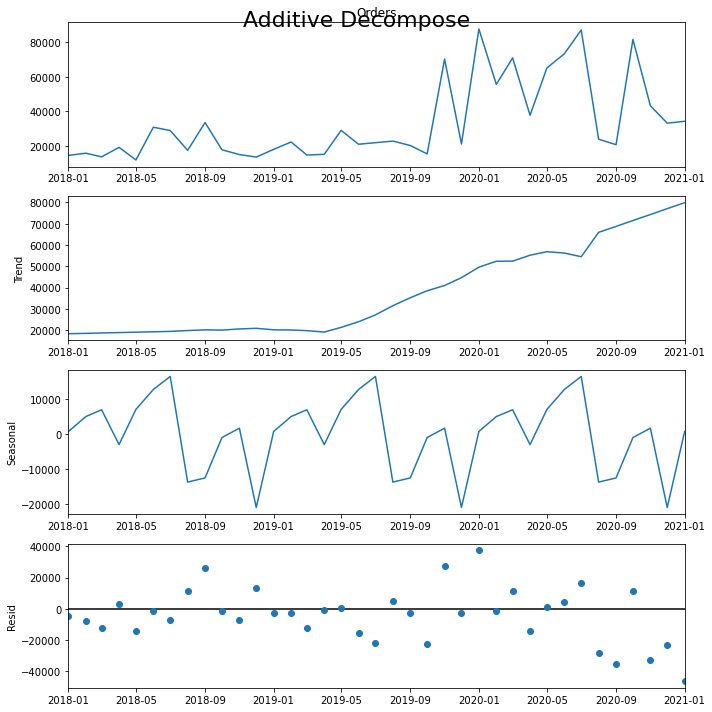

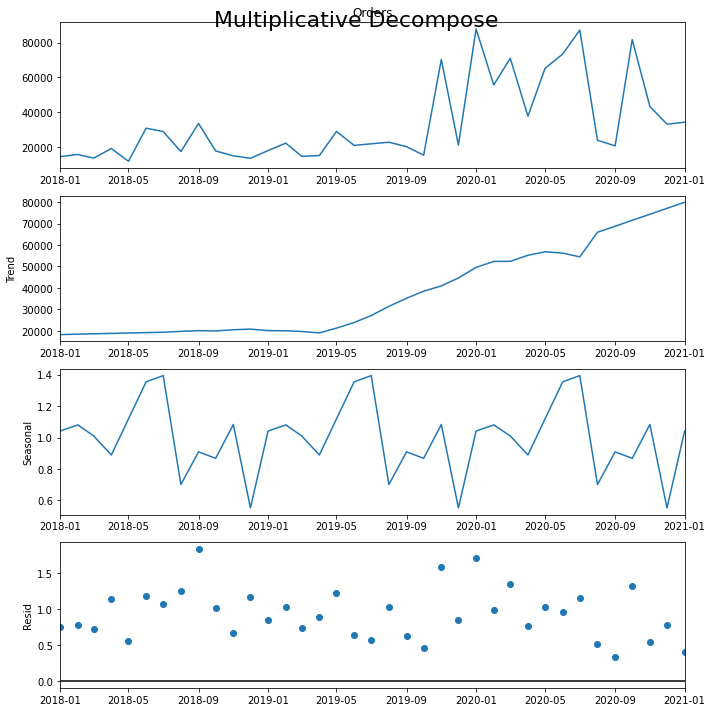

In [23]:

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df_series['Orders'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df_series['Orders'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)

plt.show()

### Let's check if the timeseries is stationary.

Using Augmented Dickey Fuller(ADF) TEST

The null hypothesis for this test is that there is a unit root(not stationary).


The alternate hypothesis is that the time series is stationary (or trend-stationary).

ARIMA depend on the values p, d, q

p = number of lags, AR terms (Order of Auto Regressive term)

d = order of differencing (Min number of differencing needed to make series stationary, if already stationary then d=0)

q = number of lagged forecast errors, MA terms (Order of Mving Average term)

In [24]:
#Ho: It is non stationary
#H1: It is stationary

#Function to perform dickey fuller test for stationary
def adf_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [25]:
adf_test(df_series)

ADF Test Statistic : -1.1863370316211308
p-value : 0.6794453883588092
#Lags Used : 3
Number of Observations Used : 33
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


 Since the p-value is 0.679 which is greater than significance level (0.05). Therefore, we cannot reject the null hypothesis that your<strong> time-series is non-stationary.</strong>

So, we need to do differencing in order to make timeseries stationary

### Differencing the Time Series

To make the time series stationary we will use differencing method. 
<br>
<br>
Basically, differencing means subracting the next value by the current value. We will do differencing until our time-series get stationary (We will using dickey fuller test again to check for stationary)

In [26]:
#First Order Difference
df_series["Orders First Difference"]=df_series["Orders"]-df_series["Orders"].shift(1)

In [27]:
#Second Order Difference
df_series["Orders Second Difference"]=df_series["Orders"]-df_series["Orders"].shift(2)

In [28]:
df_series

,Orders,Orders First Difference,Orders Second Difference
Date,,,
2018-01-01,14375.67,NaN,NaN
2018-02-01,15635.32,1259.65,NaN
2018-03-01,13526.79,-2108.53,-848.88
2018-04-01,19046.00,5519.21,3410.68
2018-05-01,11703.39,-7342.61,-1823.40
2018-06-01,30758.99,19055.60,11712.99
2018-07-01,28804.88,-1954.11,17101.49
2018-08-01,17307.73,-11497.15,-13451.26
2018-09-01,33468.42,16160.69,4663.54


In [30]:
## Again doing dickey fuller test to check if our data is stationary after 'First Order Differencing'
adf_test(df_series['Orders First Difference'].dropna())

ADF Test Statistic : -6.36335991738718
p-value : 2.443513107864351e-08
#Lags Used : 2
Number of Observations Used : 33
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


Now, we can see that p-value is less than 0.05. Therefore, there is no Unit root and the <strong>data is Stationary after doing first order differencing

<AxesSubplot:xlabel='Date'>

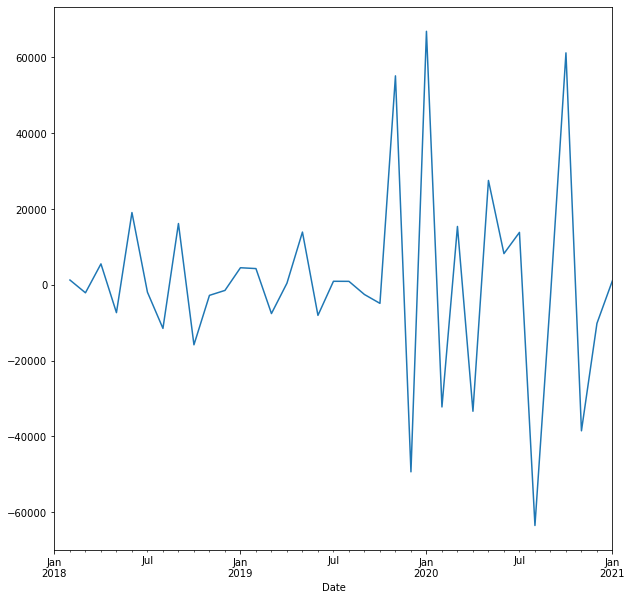

In [31]:
df_series['Orders First Difference'].plot()

<strong> We can see know that the data looks stationary now. But, there is some (small) vairance as well. </strong>

In [31]:
## Again testing dickey fuller test for 'Second order differencing'
adf_test(df_series['Orders Second Difference'].dropna())

ADF Test Statistic : -7.68918505991661
p-value : 1.4343913599733305e-11
#Lags Used : 1
Number of Observations Used : 33
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<AxesSubplot:xlabel='Date'>

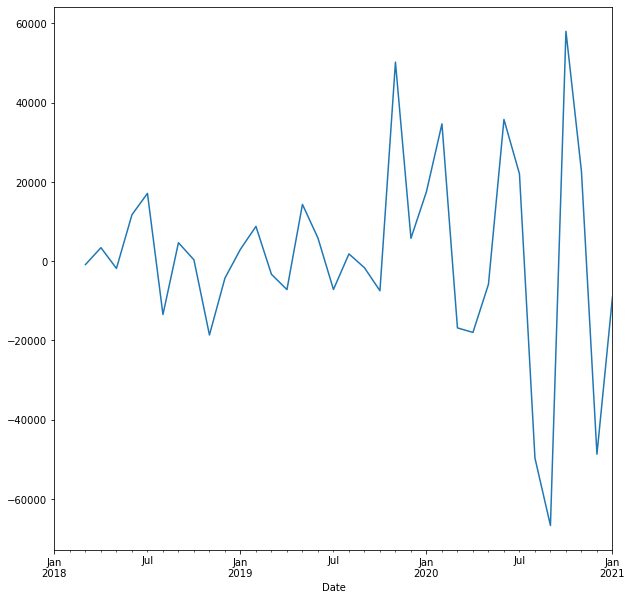

In [32]:
df_series['Orders Second Difference'].plot()

Now, if you closely observe the variance got little reduced after second order differencing.

However, we can use value of <strong>d</strong> as 1 or 2

### Autocorrelation and Partial Autocorrelation

ACF and PACF plots are used to determine the input parameters of ARIMA model. They graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps.

<strong>Autocorrelation</strong> is simply the correlation of a series with its own lags. If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value.
<br>
<br>
<strong>Partial Autocorrelation</strong> also conveys similar information but it conveys the pure correlation of a series and its lag, excluding the correlation contributions from the intermediate lags.

- Identification of an AR model is often best done with the PACF.
   - For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. In other words, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
   

- Identification of an MA model is often best done with the ACF rather than the PACF.
  - For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.

<strong>ACF</strong> measures the linear relationships between observations at different time lags.
In other words, ACF is used to understand if there exists a correlation between a time series data point with another point as a function of their time difference




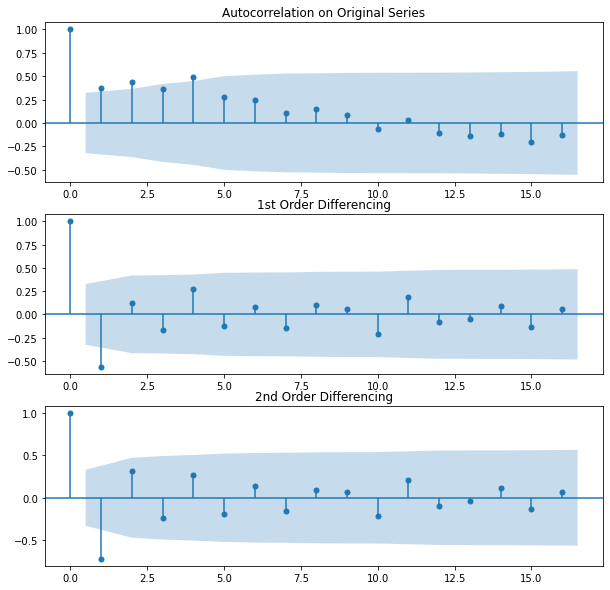

In [38]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(311)
fig = plot_acf(df_series["Orders"], ax=ax1,
               title="Autocorrelation on Original Series") 
ax2 = fig.add_subplot(312)
fig = plot_acf(df_series["Orders"].diff().dropna(), ax=ax2, 
               title="1st Order Differencing")
ax3 = fig.add_subplot(313)
fig = plot_acf(df_series["Orders"].diff().diff().dropna(), ax=ax3, 
               title="2nd Order Differencing")

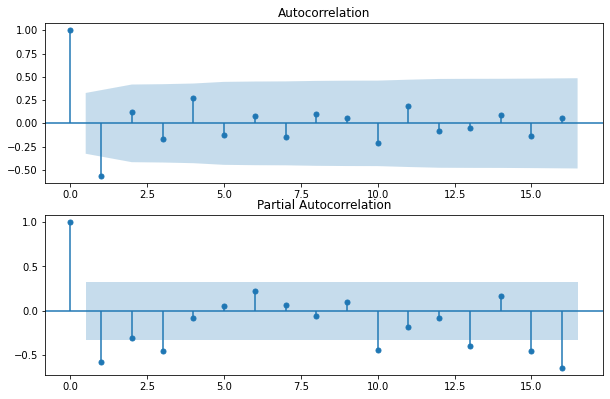

In [39]:
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(311)
fig = sm.graphics.tsa.plot_acf(df_series['Orders First Difference'].dropna(),ax=ax1)

ax2 = fig.add_subplot(312)
fig = sm.graphics.tsa.plot_pacf(df_series['Orders First Difference'].dropna(),ax=ax2)

### ARIMA Model

ARIMA has 3 component:
<br>
- AR (Autoregressive terms)<br>
- I (Differencing terms)<br>
- MA (Moving Average Terms)<br>

<br>
AR and MA are quite similar, the difference is <strong> AR</strong> considers lagged time series values from previous time period, while <strong>MA</strong> considers errors from the previous period.

In [86]:
def arimamodel(df_series):
    automodel = pm.auto_arima(df_series, 
                              start_p=0, 
                              start_q=0,
                              test="adf",
                              seasonal=False,
                              trace=True)
    return automodel

In [100]:
 arimamodel(df_series['Orders'])

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=837.896, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=826.371, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=821.934, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=835.926, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=822.434, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=823.283, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=824.683, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=819.775, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=820.703, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=821.159, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=824.454, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=821.880, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.255 seconds


ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

Auto ARIMA find <strong>ARIMA(0,1,1)</strong> as optimal value .

So, below we will be try to input value ARIMA(0,1,1) manually and check how ARIMA model gets fit to the data

In [101]:
model=ARIMA(df_series.Orders,order=(0,1,1))
model_fit=model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.Orders   No. Observations:                   36
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -407.594
Method:                       css-mle   S.D. of innovations          19014.556
Date:                Wed, 17 Feb 2021   AIC                            821.188
Time:                        16:48:16   BIC                            825.938
Sample:                    02-01-2018   HQIC                           822.846
                         - 01-01-2021                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1253.5144    292.774      4.282      0.000     679.687    1827.341
ma.L1.D.Orders    -1.0000      0.133     -7.491      0.000      -1.262      -0.738
                                    

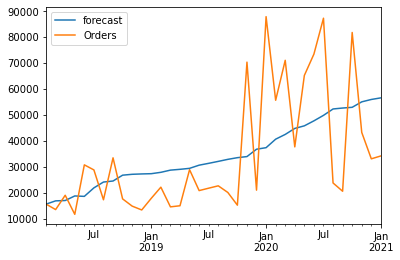

<Figure size 1200x500 with 0 Axes>

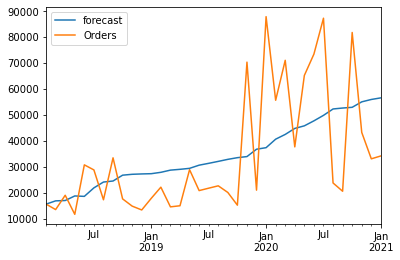

In [102]:
plt.figure(figsize=(12,5), dpi=100)
model_fit.plot_predict(dynamic=False)

As you can see, the model is not able to fit towards the data, so it won't be able to provide proper predictions

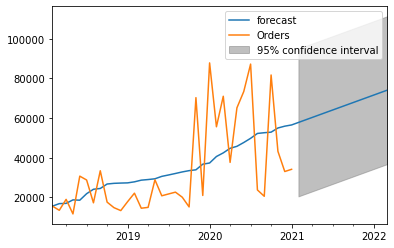

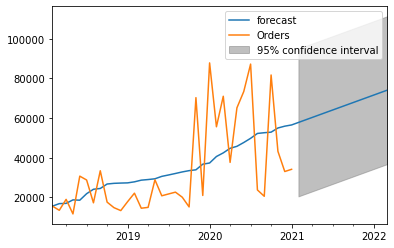

In [103]:
model = ARIMA(df_series["Orders"], order=(0, 1, 1))
results = model.fit()
results.plot_predict(1, 50)

ARIMA model fails to give the proper forecast since it's not able to fit towards our data

<sTRONG>Trying with ARIMA(1,1,1)

In [117]:
model=ARIMA(df_series.Orders,order=(1,1,1))
model_fit=model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.Orders   No. Observations:                   36
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -407.148
Method:                       css-mle   S.D. of innovations          19528.073
Date:                Wed, 17 Feb 2021   AIC                            822.296
Time:                        17:11:35   BIC                            828.630
Sample:                    02-01-2018   HQIC                           824.507
                         - 01-01-2021                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            791.5717   1052.806      0.752      0.452   -1271.891    2855.034
ar.L1.D.Orders    -0.1999      0.217     -0.920      0.357      -0.626       0.226
ma.L1.D.Orders    -0.6368      0.182

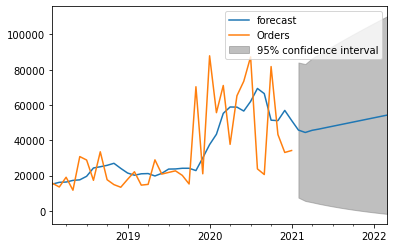

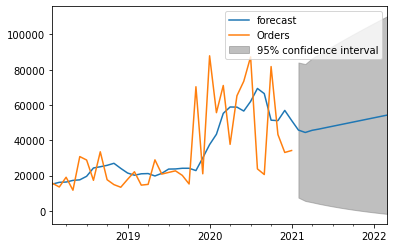

In [116]:
model = ARIMA(df_series["Orders"], order=(1, 1, 1))
results = model.fit()
results.plot_predict(1, 50)

Again, model is not fitting the data and not providing relevant forecast

### SARIMA

Creating an Auto ARIMA model(with seasonal=True) which finds the optimal value for p,d,q and P,D,Q(seasonal compnents) itself. The value with the lowest AIC score will be chosen by the auto model

In [75]:
import pmdarima as pm

smodel = pm.auto_arima(df_series['Orders'], start_p=0, start_q=0,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,1,1)[12]             : AIC=577.546, Time=0.02 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=584.749, Time=0.01 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=inf, Time=0.05 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=559.633, Time=0.04 sec
 ARIMA(0,2,1)(0,1,0)[12]             : AIC=560.574, Time=0.02 sec
 ARIMA(0,2,1)(1,1,1)[12]             : AIC=559.905, Time=0.06 sec
 ARIMA(0,2,1)(0,1,2)[12]             : AIC=560.813, Time=0.06 sec
 ARIMA(0,2,1)(1,1,0)[12]             : AIC=557.923, Time=0.04 sec
 ARIMA(0,2,1)(2,1,0)[12]             : AIC=559.905, Time=0.08 sec
 ARIMA(0,2,1)(2,1,1)[12]             : AIC=561.905, Time=0.18 sec
 ARIMA(0,2,0)(1,1,0)[12]             : AIC=inf, Time=0.04 sec
 ARIMA(1,2,1)(1,1,0)[12]             : AIC=545.944, Time=0.11 sec
 ARIMA(1,2,1)(0,1,0)[12]             : AIC=548.545, Time=0.03 sec
 ARIMA(1,2,1)(2,1,0)[12]             : AIC=547.903, Time=0.20 sec
 ARIMA(1,2,1)(1,1,1)[12]             : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   37
Model:             SARIMAX(1, 2, 1)x(1, 1, [], 12)   Log Likelihood                -268.972
Date:                             Wed, 17 Feb 2021   AIC                            545.944
Time:                                     15:20:53   BIC                            550.486
Sample:                                          0   HQIC                           547.086
                                              - 37                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6170      0.421     -1.465      0.143      -1.442       0.208
ma.L1         -0.9295      0.271     -3.429      0.001      -1.461      -0.398
ar.S.L12      -0.8420      0.962     -0.875      0.382      -2.728       1.044
sigma2      1.274e+09   5.92e-10   2.15e+18      0.000    1.27e+09    1.27e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.87   Jarque-Bera (JB):                 3.73
Prob(Q):                              0.35   Prob(JB):                         0.16
Heteroskedasticity (H):              26.43   Skew:                             0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.29e+34. Standard errors may be unstable.
"""

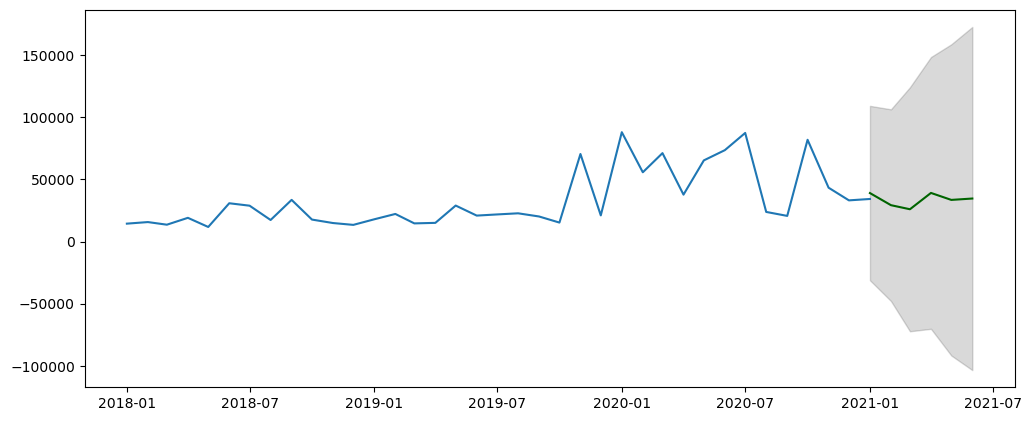

In [76]:
plt.figure(figsize=(12,5), dpi=100)
# Forecast
n_periods = 6 #Number of months you want to predict
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df_series.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df_series['Orders'])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

Here, i think SARIMA model did a pretty reasonable job of predicting the future values. Here we have predicted next 6 months of sales orders. 

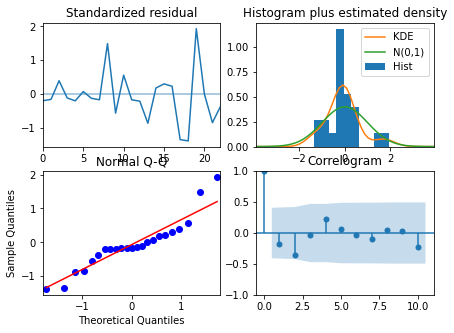

In [77]:
smodel.plot_diagnostics(figsize=(7,5))
plt.show()

- From the normal Q-Q plot we can see we don't get 100% stratight line, meaning all our data points are not being explained by our model
- Correlogram on the bottom right suggests that there is no autocorrelation in the residuals, and so they are effectively white noise

## Conclusion:

From the above analysis we can say that SARIMA model provides better forecast and fit reasonably well to our data.
However, there is still alot that can be done by trying to apply advance time series models. Also, we can try converting this into a Supervised Machine learning problem. We haven't done that in this analysis because the data was quite less.

    
In our further analysis we will try to take more historical data and do analysis on that in hope of better results/predictions
